In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 
dados = pd.read_csv('dados/Sales.csv', sep=',')
dados['Date'] = pd.to_datetime(dados['Date'])
dados = dados.sort_values(by='Date', ascending=True)

In [3]:
dados.head()

,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
60993,2011-01-01,1,January,2011,42,Adults (35-64),M,United States,California,Bikes,Road Bikes,"Road-750 Black, 44",1,344,540,185,344,529
58729,2011-01-01,1,January,2011,33,Young Adults (25-34),F,France,Yveline,Bikes,Road Bikes,"Road-150 Red, 48",2,2171,3578,1097,4342,5439
58913,2011-01-01,1,January,2011,17,Youth (<25),M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44",1,1519,2443,900,1519,2419
63711,2011-01-01,1,January,2011,39,Adults (35-64),M,United States,Washington,Bikes,Road Bikes,"Road-550-W Yellow, 38",3,713,1120,482,2139,2621
49787,2011-01-01,1,January,2011,23,Youth (<25),M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46",1,1252,2295,561,1252,1813


In [4]:
dados.columns.to_list()

['Date',
 'Day',
 'Month',
 'Year',
 'Customer_Age',
 'Age_Group',
 'Customer_Gender',
 'Country',
 'State',
 'Product_Category',
 'Sub_Category',
 'Product',
 'Order_Quantity',
 'Unit_Cost',
 'Unit_Price',
 'Profit',
 'Cost',
 'Revenue']

In [7]:
dados['Product'].unique()

array(['Road-750 Black, 44', 'Road-150 Red, 48', 'Road-250 Red, 44',
       'Road-550-W Yellow, 38', 'Mountain-200 Black, 46',
       'Road-550-W Yellow, 40', 'Road-250 Red, 58',
       'Road-550-W Yellow, 48', 'Mountain-200 Silver, 42',
       'Road-550-W Yellow, 44', 'Road-750 Black, 48',
       'Mountain-200 Black, 38', 'Road-150 Red, 44', 'Road-650 Red, 62',
       'Road-150 Red, 52', 'Road-350-W Yellow, 48', 'Road-650 Black, 60',
       'Road-650 Red, 48', 'Road-150 Red, 62', 'Mountain-500 Black, 44',
       'Road-350-W Yellow, 40', 'Road-750 Black, 52',
       'Road-350-W Yellow, 42', 'Road-650 Black, 48',
       'Road-350-W Yellow, 44', 'Mountain-200 Black, 42',
       'Road-250 Black, 52', 'Road-150 Red, 56',
       'Mountain-200 Silver, 38', 'Road-250 Black, 58',
       'Mountain-500 Black, 40', 'Mountain-400-W Silver, 42',
       'Road-250 Black, 44', 'Road-250 Black, 48',
       'Road-550-W Yellow, 42', 'Mountain-100 Silver, 44',
       'Road-750 Black, 58', 'Mountain-100 Bl

# Filtrando
## Road 250

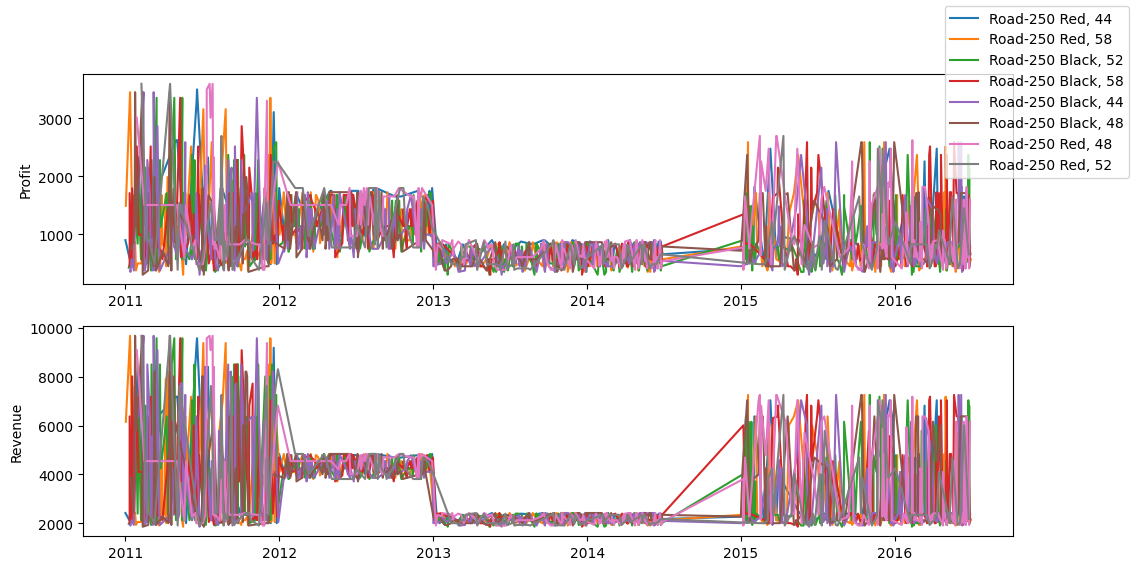

In [9]:
road_250 = dados[dados['Product'].str.contains('Road-250')]
fig_road_250, ax_road_250 = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

for produto in road_250['Product'].unique():
    df = road_250[road_250['Product'] == produto]
    ax_road_250[0].plot(df['Date'], df['Profit'], label=produto)
    ax_road_250[1].plot(df['Date'], df['Revenue'])

ax_road_250[0].set_ylabel('Profit')
ax_road_250[1].set_ylabel('Revenue')
fig_road_250.legend(loc='upper right')


In [ ]:
# Mountain 500

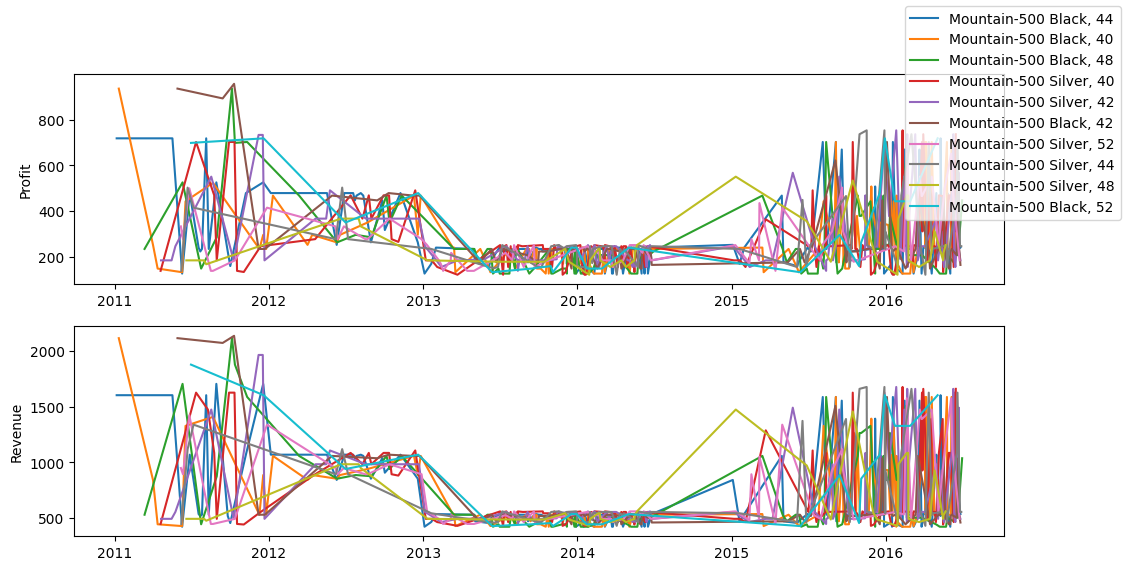

In [10]:
mountain_500 = dados[dados['Product'].str.contains('Mountain-500')]

fig_mountain_500, ax_mountain_500 = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 6)
)

for produto in mountain_500['Product'].unique():
    df = mountain_500[mountain_500['Product'] == produto]
    ax_mountain_500[0].plot(df['Date'], df['Profit'], label=produto)
    ax_mountain_500[1].plot(df['Date'], df['Revenue'])

ax_mountain_500[0].set_ylabel('Profit')
ax_mountain_500[1].set_ylabel('Revenue')
fig_mountain_500.legend(loc='upper right')
